# **Regression Analysis for Predicting Success on College Exams**

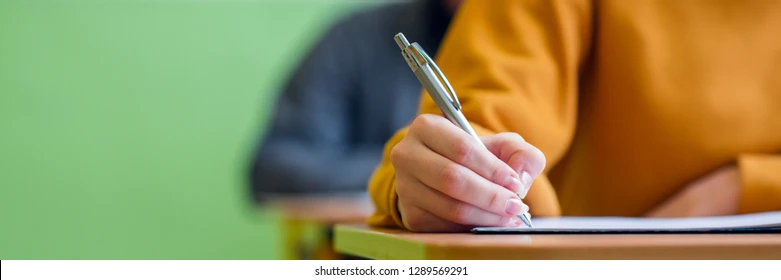

## **Business Understanding**


The transition from high school to college can be daunting, marked by increased academic rigor, newfound independence, and the pressure to succeed. The academic workload often surpasses that of high school, requiring efficient time management and effective study habits. Moreover, the social environment is drastically different, with a larger and more diverse student body. This can lead to feelings of isolation or anxiety for some freshmen. Understanding the key variables that contribute to high exam scores can significantly alleviate stress and improve academic performance. By identifying effective study techniques, time management strategies, and seeking support from professors and peers, freshmen can better navigate the challenges of college and achieve their academic goals.

I was a high school educator for eight years and I want to use my data science understanding to help high school students with this transition.  High school seniors, parents of high school seniors, high school educators, and colleges/universities are directly impacted by this topic.  Understanding the variables that go into successful college exam scores will help alleviate stress on the students.  This will give parents more confidence that their student will be successful in college while also reducing the risk of losing money they are investing in their students' education.  High school educators will be able to use this knowledge to be better at preparing their students for college and universities will see a financial benefit as the number of dropouts will be reduced.


## **Data Understanding**




The [data](https://www.kaggle.com/datasets/lainguyn123/student-performance-factors/data) I’m using for this analysis comes from  the data science community website, [Kaggle](https://www.kaggle.com/).  There are 20 features and 6,607 records that are described clearly. The features include:  hours studied, attendance, parental involvement, participation in extracurricular activities, sleep, previous scores, motivation, internet access, tutoring, family income, teacher quality, school type, peer influence, physical activity, learning disabilities, parental education level, distance from home, and gender. The data is stored in a csv file with integer and object variables.  Descriptive statistics and value counts are available for all of the numerical and categorical data in the set.

These data are suitable for this project because the features are all relavent towards things that a college student has to balance when they go to school.  There are also some features that it would be interesting to know if they are significant or not towards a student doing well on an exam.  There are some features that I would think would be interesting to add in the future.  For example, there are features on physical activity but I'd like to see if diet affects exam scores as well.  The 'freshman 15' is a well-known phenomenon where a freshman gains fifteen pounds his/her first year at college and I wonder if that impacts exam scores as well.

To understand the data I looked at the data types of all of the feautures and checked to see if there were any missing values.  There were some missing values but it was a small percentage of the total data so I dealt with this by dropping rows with missing values.  Next, I looked at the descriptive statistics of the numerical features (hours studied, attendance, sleep hours, previous scores, tutoring sessions, physical activity, and exam score) and the value counts of the categorical data (parent involvement, access to resources, extracurriculars, motivation, internet access, family income, teacher quality, school type, peer influence, learning disabilities, parent education, distance from home, and gender).  For this analysis I'm using exam score as my target variable and I'm using the other features as predictors of the exam score.

The next thing I did was look at the relationship amongst the predictor variables and the relationship between the predictor variables and the target variable. Attendance (.58) and Hours studied (.45) were moderately coorelated to exam score and all other features were not correlated.  I used scatter plots to check the coorelation and the linearity of the data.  I used a correlation matrix to check the correlation between the numerical data and found no multicollinearity.  I found a way to check the correlation of the categorical variables by using the Cramers V statstic method and made a correlation matrix with that as well and found no multicollinarity.

### **Collect Initial Data**

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression, HuberRegressor, RANSACRegressor, TheilSenRegressor, Ridge
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
import sklearn.metrics as metrics
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.metrics import confusion_matrix
from random import gauss
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats as stats
import scipy.stats as ss
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import plot_tree



%matplotlib inline

In [2]:
#Code needed to get and prepare the raw data for analysis
data = pd.read_csv('https://raw.githubusercontent.com/josh-g-grimes/Regression-Analysis---College-Exam-Performance/main/StudentPerformanceFactors.csv')

### **Describe Data**

In [3]:
#Check for missing values and data types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6607 entries, 0 to 6606
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Hours_Studied               6607 non-null   int64 
 1   Attendance                  6607 non-null   int64 
 2   Parental_Involvement        6607 non-null   object
 3   Access_to_Resources         6607 non-null   object
 4   Extracurricular_Activities  6607 non-null   object
 5   Sleep_Hours                 6607 non-null   int64 
 6   Previous_Scores             6607 non-null   int64 
 7   Motivation_Level            6607 non-null   object
 8   Internet_Access             6607 non-null   object
 9   Tutoring_Sessions           6607 non-null   int64 
 10  Family_Income               6607 non-null   object
 11  Teacher_Quality             6529 non-null   object
 12  School_Type                 6607 non-null   object
 13  Peer_Influence              6607 non-null   obje

In [4]:
#Check for missing values
data.isna().sum().sum()

235

In [5]:
#Drop Missing Values
data = data.dropna()

In [6]:
#Separate columns into numerical and categorical data
categoricals = data.select_dtypes(include='object')
numericals = data.select_dtypes(exclude='object')

In [7]:
#Loop through numerical columns to print descriptive statistics
for col in numericals:
    print(data[col].describe())
    print()

count    6378.000000
mean       19.977109
std         5.985460
min         1.000000
25%        16.000000
50%        20.000000
75%        24.000000
max        44.000000
Name: Hours_Studied, dtype: float64

count    6378.000000
mean       80.020853
std        11.550723
min        60.000000
25%        70.000000
50%        80.000000
75%        90.000000
max       100.000000
Name: Attendance, dtype: float64

count    6378.000000
mean        7.034964
std         1.468033
min         4.000000
25%         6.000000
50%         7.000000
75%         8.000000
max        10.000000
Name: Sleep_Hours, dtype: float64

count    6378.000000
mean       75.066165
std        14.400389
min        50.000000
25%        63.000000
50%        75.000000
75%        88.000000
max       100.000000
Name: Previous_Scores, dtype: float64

count    6378.000000
mean        1.495296
std         1.233984
min         0.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         8.000000
Name: Tutoring_

In [8]:
#Inspect the value counts for the categorical features
for col in categoricals.columns:
    print(categoricals[col].value_counts())
    print()

Parental_Involvement
Medium    3251
High      1836
Low       1291
Name: count, dtype: int64

Access_to_Resources
Medium    3204
High      1900
Low       1274
Name: count, dtype: int64

Extracurricular_Activities
Yes    3807
No     2571
Name: count, dtype: int64

Motivation_Level
Medium    3237
Low       1864
High      1277
Name: count, dtype: int64

Internet_Access
Yes    5893
No      485
Name: count, dtype: int64

Family_Income
Low       2582
Medium    2566
High      1230
Name: count, dtype: int64

Teacher_Quality
Medium    3826
High      1905
Low        647
Name: count, dtype: int64

School_Type
Public     4434
Private    1944
Name: count, dtype: int64

Peer_Influence
Positive    2553
Neutral     2495
Negative    1330
Name: count, dtype: int64

Learning_Disabilities
No     5710
Yes     668
Name: count, dtype: int64

Parental_Education_Level
High School     3159
College         1939
Postgraduate    1280
Name: count, dtype: int64

Distance_from_Home
Near        3801
Moderate    1941
Fa

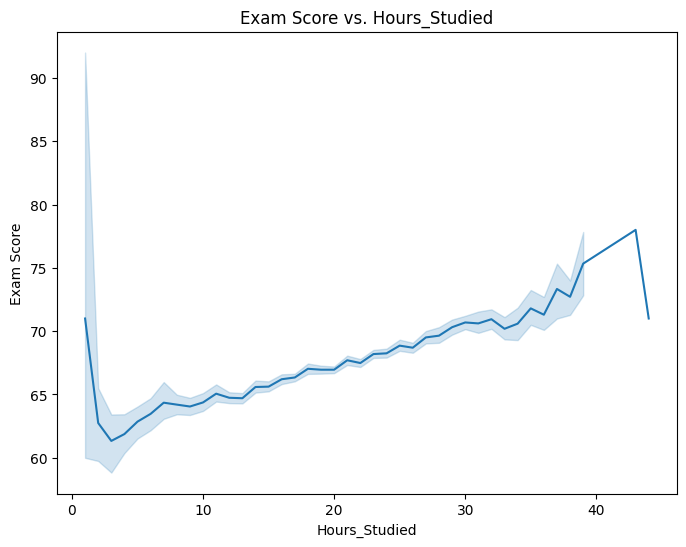

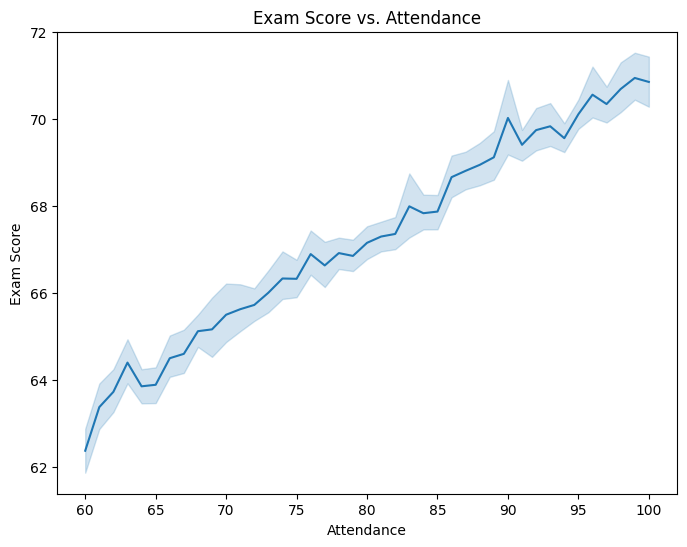

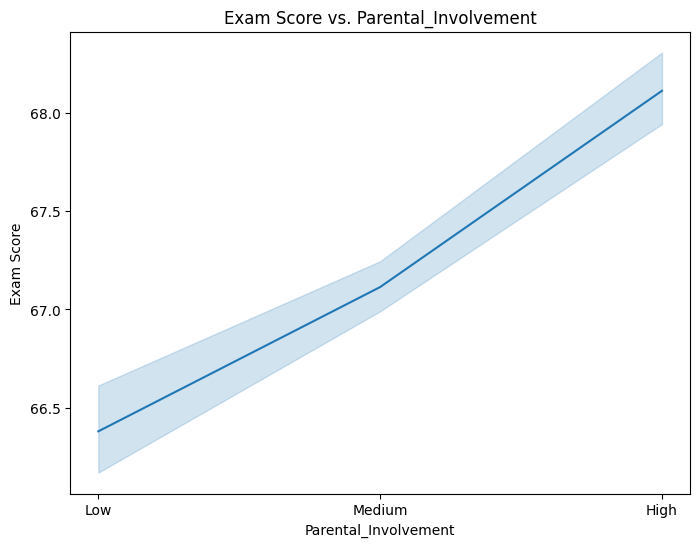

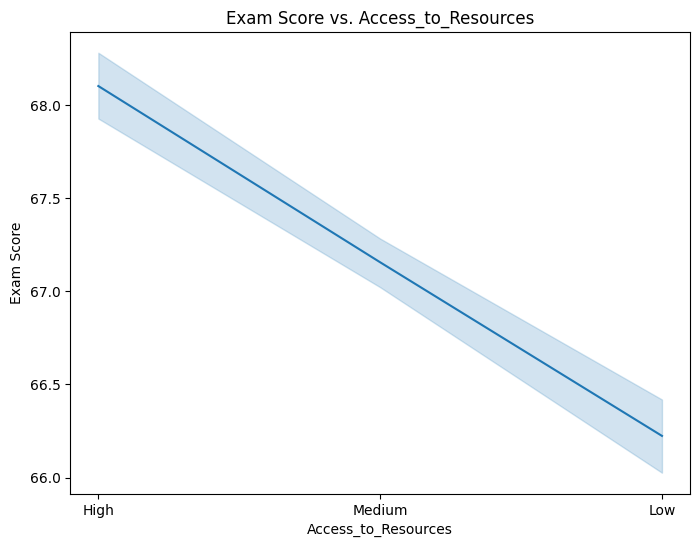

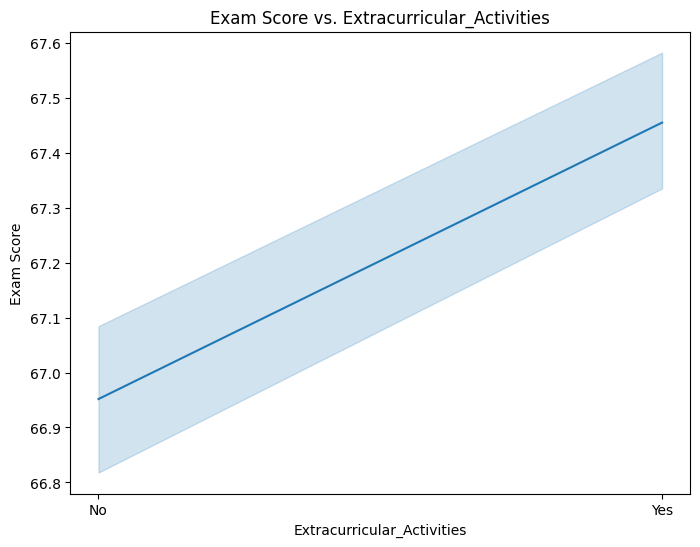

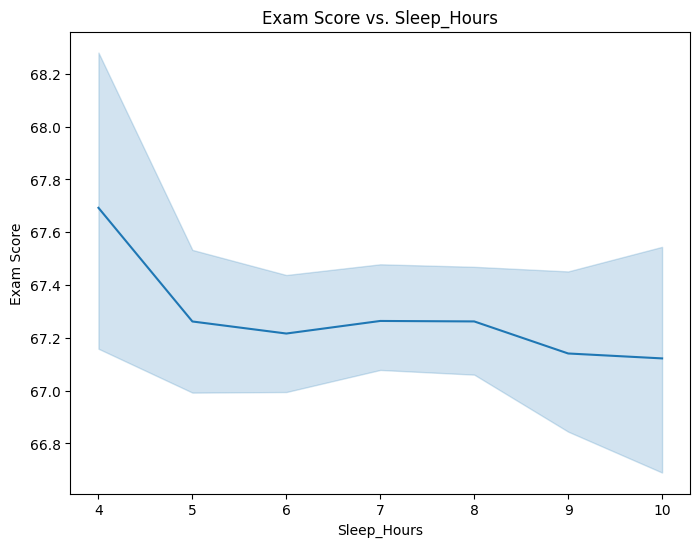

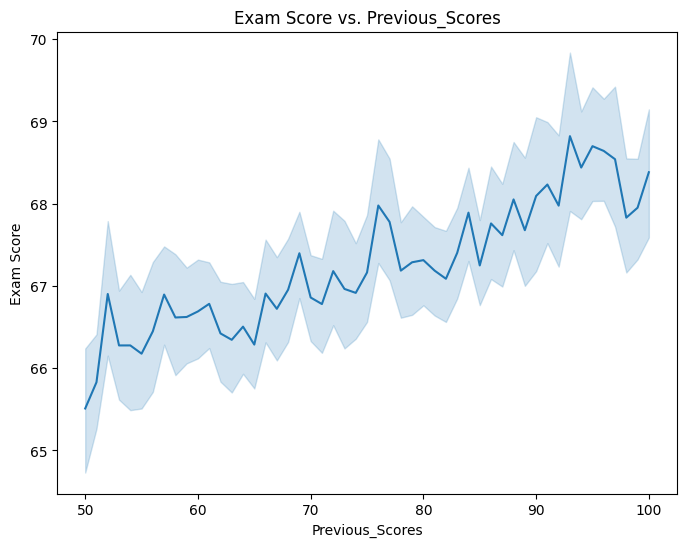

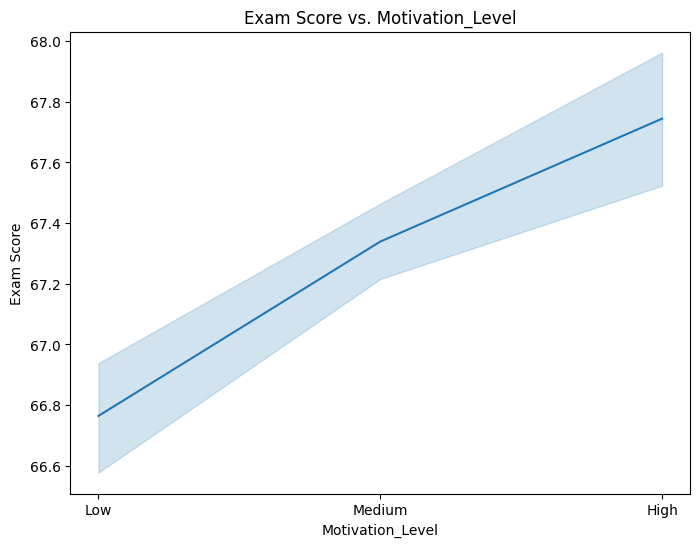

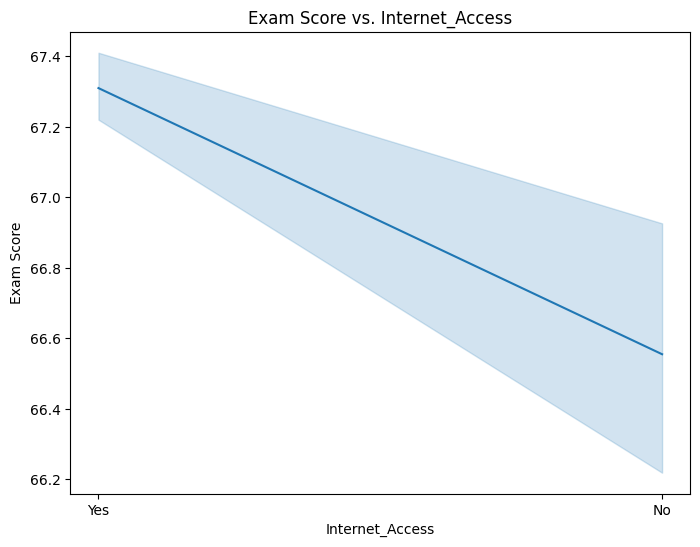

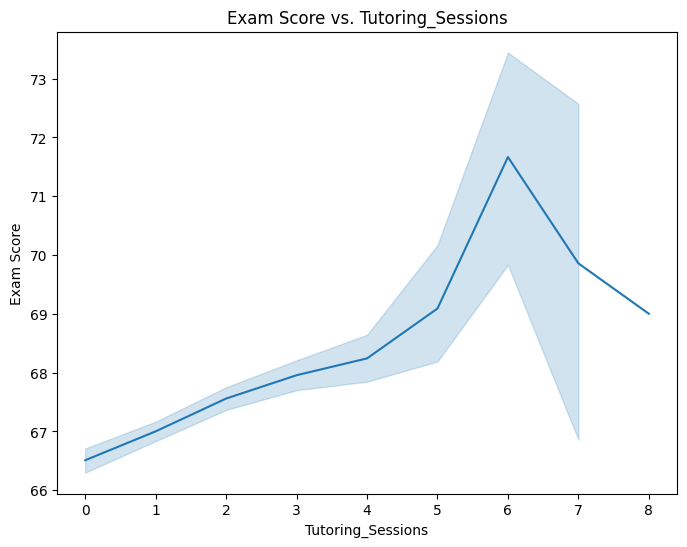

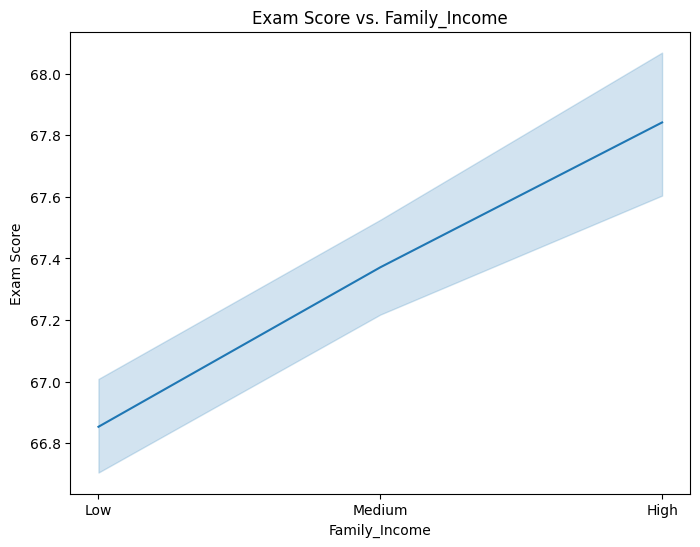

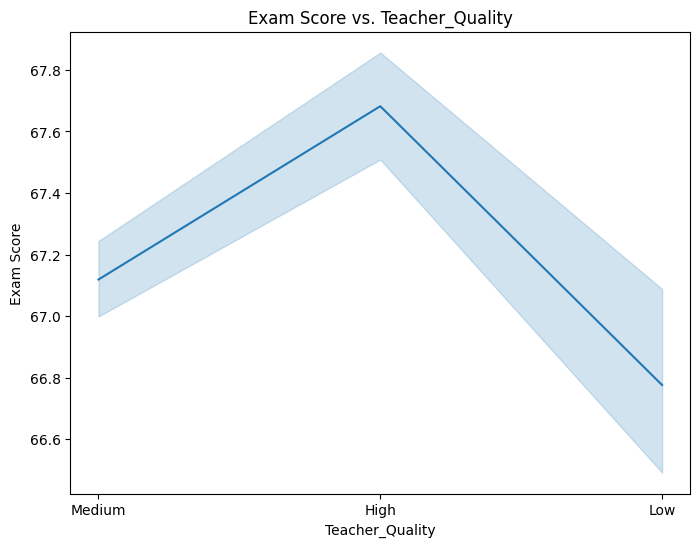

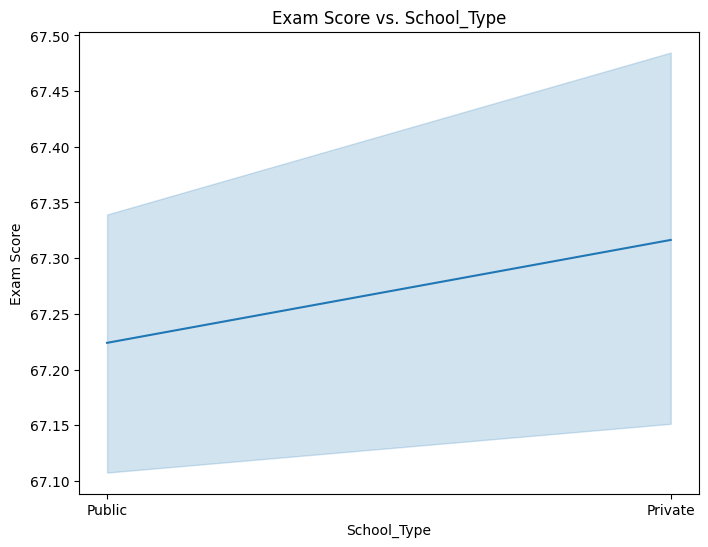

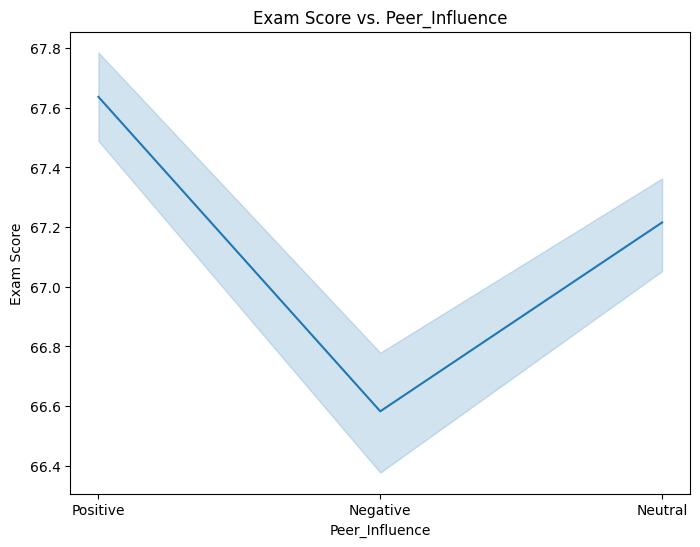

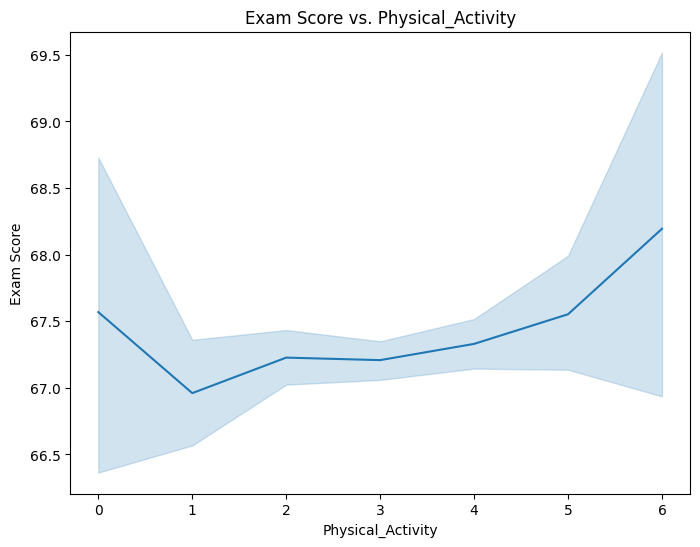

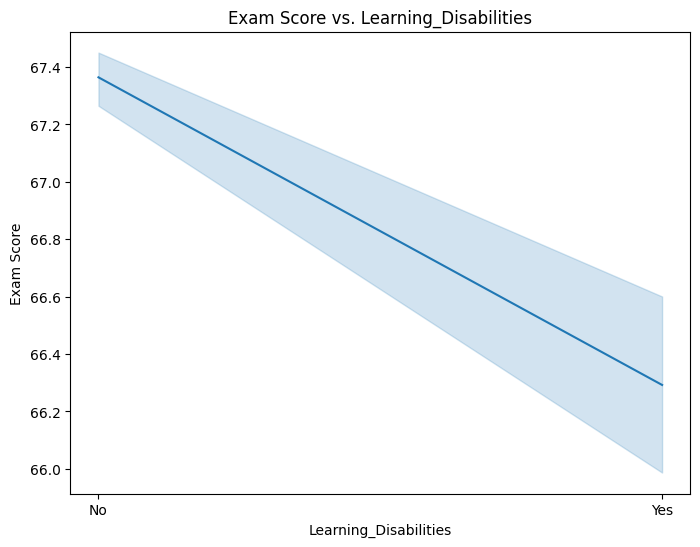

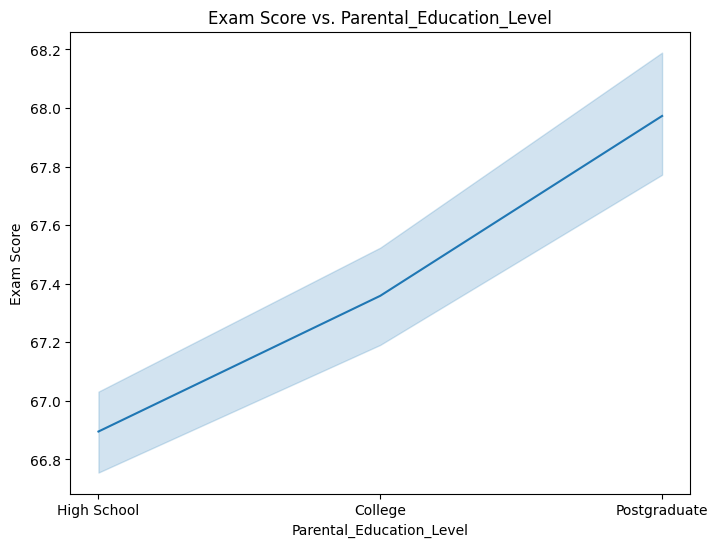

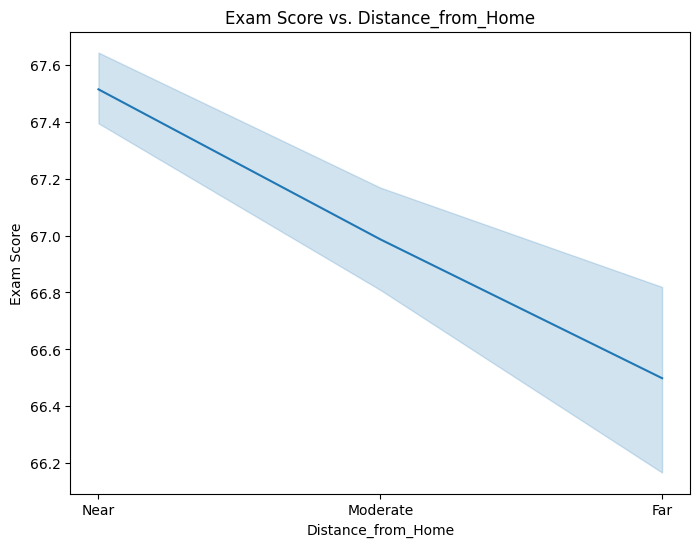

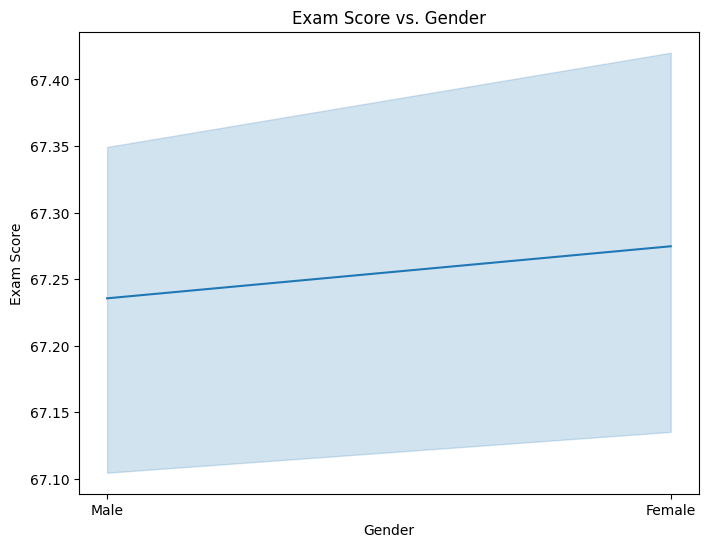

In [9]:
# Loop through each numerical column (excluding 'Exam Score')
for column in data.columns[:-1]:  # Exclude 'Exam Score' itself
  plt.figure(figsize=(8, 6))  # Adjust figure size as needed
  sns.lineplot(x=data[column], y=data['Exam_Score'])
  plt.title(f"Exam Score vs. {column}")
  plt.xlabel(column)
  plt.ylabel("Exam Score")
  plt.show()


### **Explore Data**

In [10]:
#Find the most correlated numerical value to the target variable
data.corr(numeric_only=True)["Exam_Score"].sort_values(ascending=False)

,Exam_Score
Exam_Score,1.000000
Attendance,0.580259
Hours_Studied,0.445104
Previous_Scores,0.174283
Tutoring_Sessions,0.156829
Physical_Activity,0.025148
Sleep_Hours,-0.017171


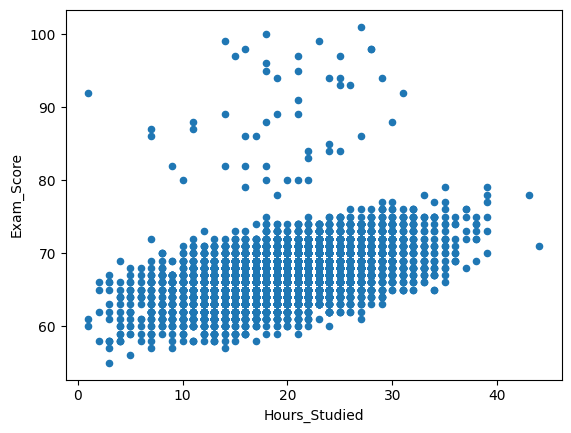

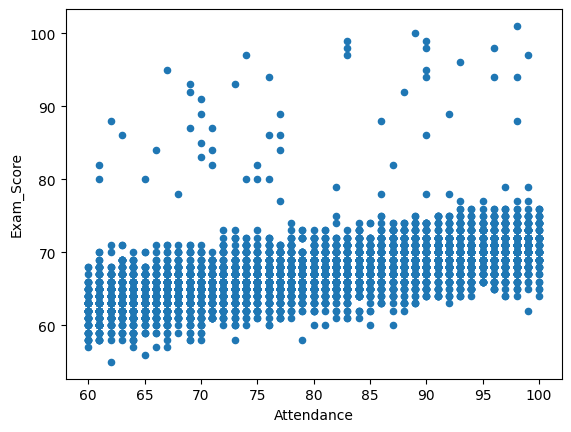

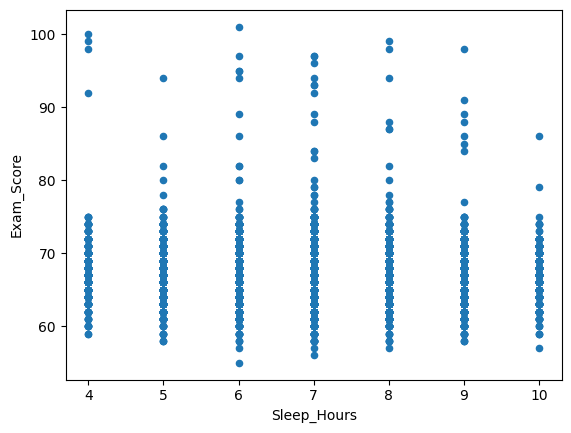

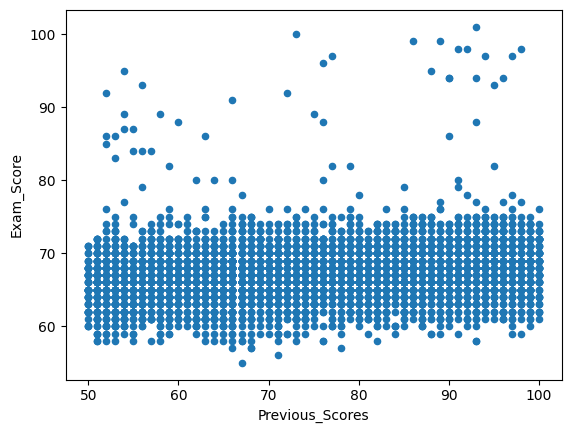

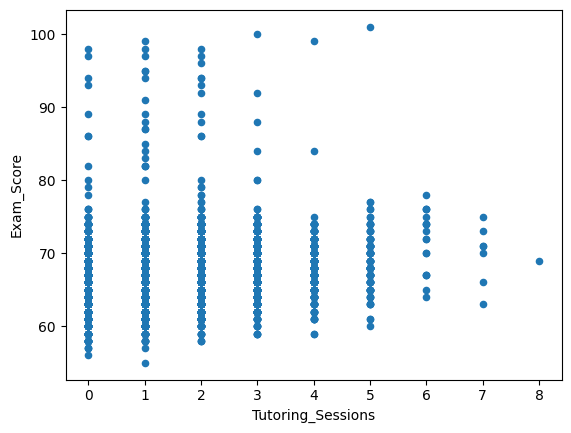

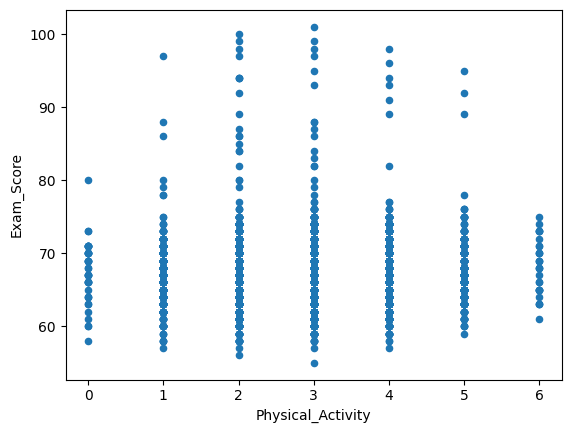

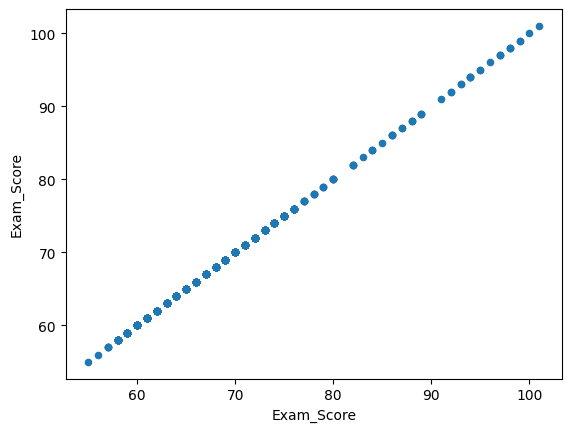

In [11]:
#Loop through the numerical columns and make scatter plots to show the relationship between them and the target variable
for col in data.corr(numeric_only=True).columns:
    data.plot.scatter(x=col, y='Exam_Score')

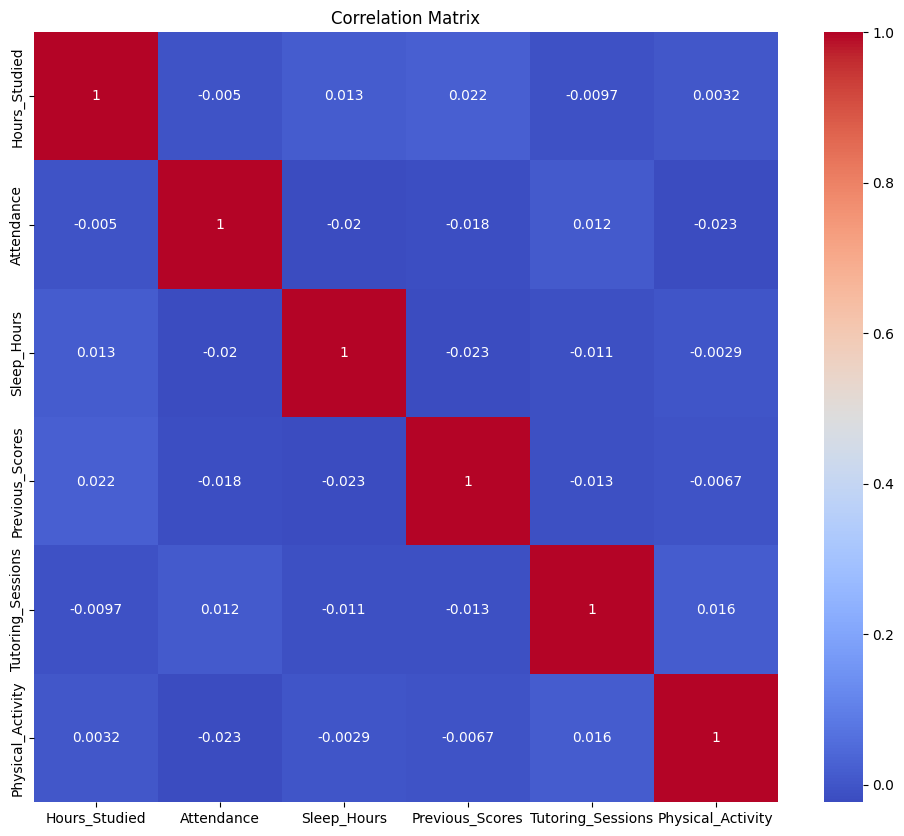

In [12]:
#create a correlation matrix of the numerical variables related to each other
correlation_matrix = numericals.drop(columns='Exam_Score').corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [13]:
#create a function to calculate Cramer's V for the categorical data
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

Source: [Stack Overflow](https://stackoverflow.com/questions/46498455/categorical-features-correlation/46498792#46498792)

In [14]:
# Iterate over each categorical column and calculate Cramér's V with 'Exam_Score'
cramers_v_scores = {}
for col in categoricals.columns:
    cramers_v_scores[col] = cramers_v(categoricals[col], data['Exam_Score'])

    # Sort the Cramér's V scores in descending order
sorted_cramers_v = dict(sorted(cramers_v_scores.items(), key=lambda x: x[1], reverse=True))

# Print the sorted Cramér's V scores
for col, score in sorted_cramers_v.items():
    print(f"{col}: {score}")

Access_to_Resources: 0.14141624384893206
Parental_Involvement: 0.12643554349868558
Learning_Disabilities: 0.12443093706886459
Parental_Education_Level: 0.08367163464587528
Peer_Influence: 0.07760455590870957
Distance_from_Home: 0.07642238156014759
Internet_Access: 0.06822152279146197
Motivation_Level: 0.06516068475806391
Family_Income: 0.06448738612047515
Extracurricular_Activities: 0.06374559401534015
Teacher_Quality: 0.05178274514643499
Gender: 0.037226928401334625
School_Type: 0.0


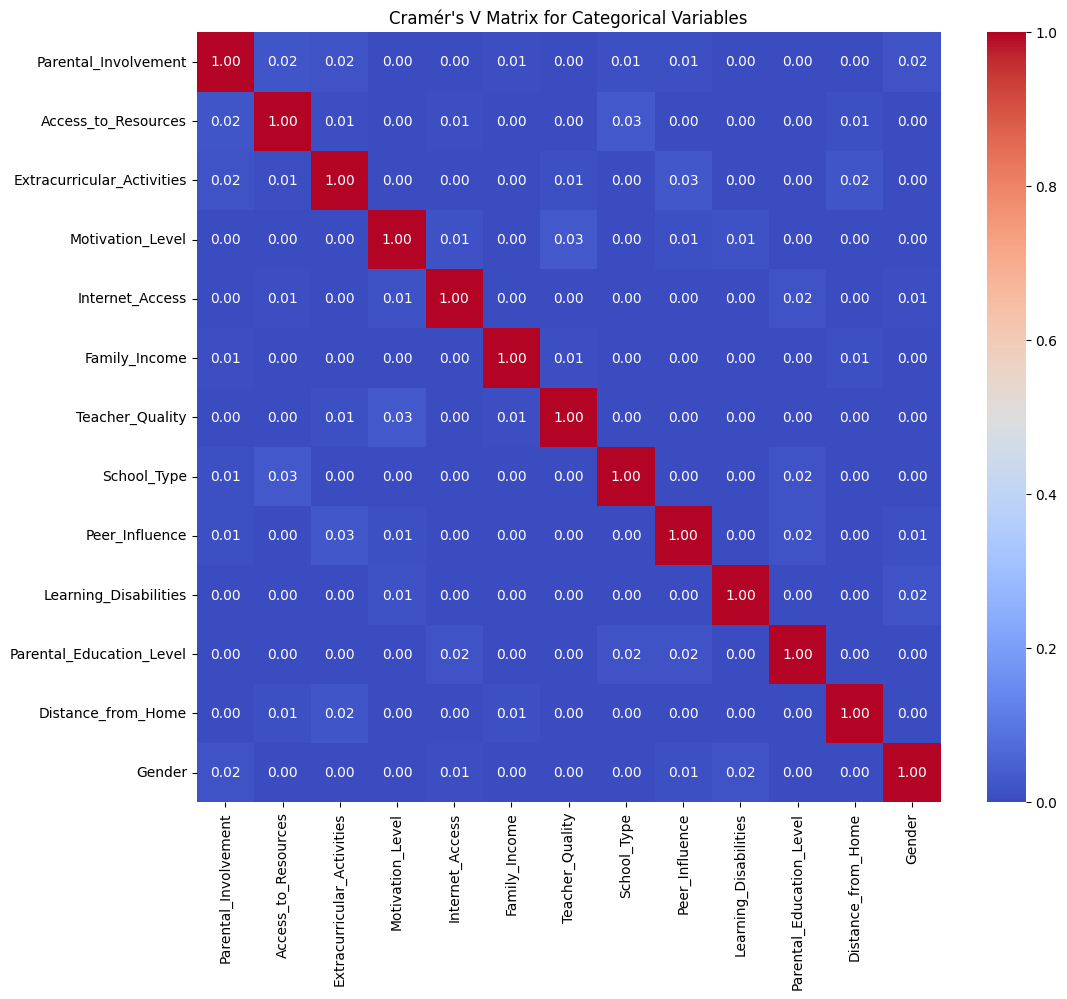

In [15]:
# Create an empty matrix to store Cramer's V values
cramers_v_matrix = pd.DataFrame(index=categoricals.columns, columns=categoricals.columns)

# Iterate through all pairs of categorical columns
for col1 in categoricals.columns:
    for col2 in categoricals.columns:
        cramers_v_matrix.loc[col1, col2] = cramers_v(categoricals[col1], categoricals[col2])

# Convert the Cramér's V matrix to numeric type
cramers_v_matrix = cramers_v_matrix.apply(pd.to_numeric)

# Create the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(cramers_v_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Cramér\'s V Matrix for Categorical Variables')
plt.show()

### **Data Preparation**

To prepare the data for this analysis I assigned the predictor features to the X variable and the target score to the y variable.  Then I split the data into a training set (80%), a test set (10%), and a validation set (10%) to avoid data leakage. I used the training data to train and pick the best performing model.  I used the validation set to evaluate the best model and tune the hyperparamters.  I used the test set as an unseen data set to provide an unbiased final evaluation of the best model with the best hyperparameters.

To prepare the data for analysis I also created dummy variables for each of the categorical features.  I did this so that each of the categorical features will be represented by a 0 or a 1 for the model to analyze.  I dropped the first column from each category in order to avoid multicollinearity.  I then needed to change the datatype to float so the modeling will work.   

I dropped insignificant features from the data to see if that improved the modeling metrics.  I also scaled the data to better understand how changes in the coefficients would impact the target variable.  

In [16]:
#assign predictor and target variables
X = data.drop(columns= 'Exam_Score', axis=1)
y = data['Exam_Score']

In [17]:
#Split the data into 80% training data and 20% test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
#split the test data in half so 10% of the original data is test data and 10% of the original data is validation data
X_validate, X_test, y_validate, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [19]:
#one hot encode the categorical features of each of the data sets
X_train = pd.get_dummies(X_train, drop_first=True)
X_validate = pd.get_dummies(X_validate, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

In [20]:
#Change the variable types to float so the modeling will work
X_train = X_train.astype(float)
X_validate = X_validate.astype(float)
X_test = X_test.astype(float)

### **Modeling**

I chose to do a linear regression analysis because I am using variables to predict a continuous target varaibel.  I chose mean absolute error (MAE) as the target metric.  Mean absolute error is expressed at the same scale as the target variable so it is easy to interpret.  All errors are treated equally, so the metric is robus to outliers.  Also, it disregards the direction of erros, so underforecasting is the same as overforecasting.  I chose the metric that is robost to outliers because the data does contain outliers in the numberical categories.  I also wanted to put an emphasis on underforecasting because I'd rather the model predict a student get a grade and then the student get a higher grade than was expected than have the model predict a grade and the student get a lower grade than expected. I also used r-square score as a comparison metric to show the explanation of variance between the models and improvement from hyperparameter tuning.

I chose a single linear regression model using the highest correlated feature to the target variable as my baseline model.  The model and variable were statistically significant with a R-squared score of .331 and a MAE score of 2.073.  

I chose five other linear regression models to compare to my baseline model.  These were a multiple linear regression model using all of the features,  random forest regressor, k-nearest neighbors regressor, ransac regressor, and support vector machine regression.  The highest performing model of these was the  ransac regressor.  This model had a MAE score of .421 and an R-squared score of .733.  This was a 1.652 improvement on MAE score and a .402 improvement on R-squared score.  This means the ransac model can explain 40% more of the variance than the baseline model and has 1.652 less error on a 100 point scale than the baseline model.  This is important because that is 2 points on an exam score which means I'm reducing the error by potentially a whole exam question depending on how many questions there are on the exam.  

Next, I looked for ways to improve the ransac regressor model using the validation data.  First, I tried dropping the features that weren't significant to the model.  These features were: sleep hours, school type (public vs. private), and gender.  This very slightly improved the MAE (.0003) and R-squared (.0002).  However, there was improvement so I left these features out as I continued modeling.

Next, I scaled the data using a standard scalar.  This didn't impact the metrics as this process is only done to make the coefficients more interpretable by keeping them on the same scale.  

Finally, I ran a gridsearch on the most important hyperparamters of a ransac regression model and applied them to the model.  This made the model's MAE worse by .03.  Therefore, I made the final model the ransac model with default hyperparamaters.

#### Model Comparison

In [21]:
#Create a baseline model using only the most correlated variable
baseline_model = sm.OLS(y_train, sm.add_constant(X_train['Attendance']))
baseline_model = baseline_model.fit()
print(baseline_model.summary())

                            OLS Regression Results                            
Dep. Variable:             Exam_Score   R-squared:                       0.331
Model:                            OLS   Adj. R-squared:                  0.331
Method:                 Least Squares   F-statistic:                     2528.
Date:                Mon, 23 Sep 2024   Prob (F-statistic):               0.00
Time:                        17:26:36   Log-Likelihood:                -13165.
No. Observations:                5102   AIC:                         2.633e+04
Df Residuals:                    5100   BIC:                         2.635e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         51.6783      0.313    165.167      0.0

In [22]:
#Calculate the Mean Absolute Error of the single regression model
baseline_mae = mean_absolute_error(y_validate, baseline_model.predict(sm.add_constant(X_validate['Attendance'])))
baseline_mae

2.0728406135658806

In [23]:
#Create a multiple regression model with all of the features
multiple_regression = sm.OLS(y_train, sm.add_constant(X_train))
multiple_regression = multiple_regression.fit()
print(multiple_regression.summary())

                            OLS Regression Results                            
Dep. Variable:             Exam_Score   R-squared:                       0.719
Model:                            OLS   Adj. R-squared:                  0.717
Method:                 Least Squares   F-statistic:                     480.3
Date:                Mon, 23 Sep 2024   Prob (F-statistic):               0.00
Time:                        17:26:36   Log-Likelihood:                -10956.
No. Observations:                5102   AIC:                         2.197e+04
Df Residuals:                    5074   BIC:                         2.215e+04
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

In [24]:
#calculate and print mae for multiple regression model
multiple_regression_mae = mean_absolute_error(y_validate, multiple_regression.predict(sm.add_constant(X_validate)))
multiple_regression_mae

0.47776100797125953

In [25]:
#fit and evaluate a random forest regressor
random_forest = RandomForestRegressor()
random_forest.fit(X_train, y_train)
y_pred_rf = random_forest.predict(X_validate)
random_forest_mae = mean_absolute_error(y_validate, y_pred_rf)
print("Mean Absolute Error:", random_forest_mae)
random_forest_r2 = r2_score(y_validate, y_pred_rf)
print("R-Squared:", random_forest_r2)

Mean Absolute Error: 1.2110188087774292
R-Squared: 0.6203610691373272


In [26]:
#fit and evaluate a k-nearest neightbors regressor
knn = KNeighborsRegressor()
knn.fit(X_train, y_train)
y_pred = knn.predict(X_validate)
knn_mae = mean_absolute_error(y_validate, y_pred)
print("Mean Absolute Error:", knn_mae)
knn_r2 = r2_score(y_validate, y_pred)
print("R-Squared:", knn_r2)

Mean Absolute Error: 1.5410658307210037
R-Squared: 0.5097361057409509


In [27]:
#fit and evaluate a ranscac regressor
ransac = RANSACRegressor()
ransac.fit(X_train, y_train)
y_pred = ransac.predict(X_validate)
ransac_mae = mean_absolute_error(y_validate, y_pred)
print("Mean Absolute Error:", ransac_mae)
ransac_r2 = r2_score(y_validate, y_pred)
print("R-Squared:", ransac_r2)

Mean Absolute Error: 0.4204237401137917
R-Squared: 0.7331031492871605


In [28]:
#Fit and evaluate a support vector machine regressor
svr = SVR()
svr.fit(X_train, y_train)
y_pred = svr.predict(X_validate)
svr_mae = mean_absolute_error(y_validate, y_pred)
print("Mean Absolute Error:", svr_mae)
svr_r2 = r2_score(y_validate, y_pred)
print("R-Squared:", svr_r2)

Mean Absolute Error: 1.2956250871630397
R-Squared: 0.5992914375515348


#### Best Model Tuning

In [29]:
#assign ransac to the best model variable
best_model = ransac

In [30]:
#drop the non-significant features from the baseline model
X_train_sig = X_train.drop(columns=['Sleep_Hours', 'School_Type_Public', 'Gender_Male'])
X_validate_sig = X_validate.drop(columns=['Sleep_Hours', 'School_Type_Public', 'Gender_Male'])

In [31]:
#fit and evaluate the ransac regression model on only the significant features from the baseline model
best_model_sig = RANSACRegressor()
best_model_sig.fit(X_train_sig, y_train)
y_pred_sig = best_model_sig.predict(X_validate_sig)
best_model_sig_mae = mean_absolute_error(y_validate, y_pred_sig)
print("Mean Absolute Error:", best_model_sig_mae)
best_model_sig_r2 = r2_score(y_validate, y_pred_sig)
print("R-Squared:", best_model_sig_r2)

Mean Absolute Error: 0.419243753519778
R-Squared: 0.7323823797210399


In [32]:
#Scale the training and validation data
scalar = StandardScaler()
X_train_scaled = scalar.fit_transform(X_train_sig)
X_validate_scaled = scalar.transform(X_validate_sig)

In [33]:
#Fit and evaluate ransac model with scaled variables
best_model_scaled = RANSACRegressor()
best_model_scaled.fit(X_train_scaled, y_train)
y_pred_scaled = best_model_scaled.predict(X_validate_scaled)
best_model_scaled_mae = mean_absolute_error(y_validate, y_pred_scaled)
print("Mean Absolute Error:", best_model_scaled_mae)
best_model_scaled_r2 = r2_score(y_validate, y_pred_scaled)
print("R-Squared:", best_model_scaled_r2)

Mean Absolute Error: 0.41897107243305043
R-Squared: 0.732456945455287


In [34]:
#Grid search of important hyperparameters from ransac regression
param_grid = {
    'min_samples': [None, 100, 500],
    'max_trials': [100, 1000, 10000],
    'loss': ['absolute_error', 'squared_error'],
    'stop_n_inliers': [1, 5, 9],
    'stop_score': [1, 5, 9],
    'max_skips': [1, 5, 9],
}

grid_search = GridSearchCV(RANSACRegressor(), param_grid, cv=5)
grid_search.fit(X_validate, y_validate)

GridSearchCV(cv=5, estimator=RANSACRegressor(),
             param_grid={'loss': ['absolute_error', 'squared_error'],
                         'max_skips': [1, 5, 9],
                         'max_trials': [100, 1000, 10000],
                         'min_samples': [None, 100, 500],
                         'stop_n_inliers': [1, 5, 9], 'stop_score': [1, 5, 9]})

Hyperparameter [Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)

In [35]:
#view results of the grid search
grid_search.best_params_

{'loss': 'squared_error',
 'max_skips': 1,
 'max_trials': 1000,
 'min_samples': 100,
 'stop_n_inliers': 9,
 'stop_score': 1}

In [36]:
#Fit and Evaluate ransac model with the hyperparameters from the grid search
best_model_best_params = RANSACRegressor(loss = 'squared_error', max_skips=1, max_trials=1000, min_samples=100, stop_n_inliers=9, stop_score=1, random_state=42)
best_model_best_params.fit(X_train_scaled, y_train)
y_pred_best_params = best_model_best_params.predict(X_validate_scaled)
best_model_best_params_mae = mean_absolute_error(y_validate, y_pred_best_params)
print("Mean Absolute Error:", best_model_best_params_mae)
best_model_best_params_r2 = r2_score(y_validate, y_pred_best_params)
print("R-Squared:", best_model_best_params_r2)

Mean Absolute Error: 0.45359126645430337
R-Squared: 0.7312437524120368


### **Evaluation**

I chose mean absolute error (MAE) as the target metric. Mean absolute error is expressed at the same scale as the target variable so it is easy to interpret. All errors are treated equally, so the metric is robus to outliers. Also, it disregards the direction of erros, so underforecasting is the same as overforecasting. I chose the metric that is robost to outliers because the data does contain outliers in the numberical categories. I also wanted to put an emphasis on underforecasting because I'd rather the model predict a student get a grade and then the student get a higher grade than was expected than have the model predict a grade and the student get a lower grade than expected. I also used r-square score as a comparison metric to show the explanation of variance between the models and improvement from hyperparameter tuning.

The final model I chose was the ransac regressor model using only the scaled significant features from the baseline model.  This model had the lowest MAE and highest R-squared score of the models I evaluated.  

When I evaluated the performance of the model using the holdout test data the final metrics were MAE - .448 and R-squared - .729. I also plotted the residuals and found that there was heteroskedasticity and normality of the residuals.

I plotted the predicted results from the model with the actual test scores from the holdout data and the implications were good for the real-world problem.  The predicted exam scores were closely clustered along a line showing that the predictions were within a 1 or 2 percentage points of the actual test scores.  In the five exceptions where the actual test score wasn't close to the predicted score the actual test scores were higher than the predicted score which was my goal when choosing an evaluation metric.  

In [37]:
#apply changes to the testing data that I applied to the training and validation data
X_test_sig = X_test.drop(columns=['Sleep_Hours', 'School_Type_Public', 'Gender_Male'])
X_test_scaled = scalar.transform(X_test_sig)

In [38]:
#evaluates the final model on holdout test data
final_model = best_model_scaled
y_pred_final = final_model.predict(X_test_scaled)
final_model_mae = mean_absolute_error(y_test, y_pred_final)
print("Mean Absolute Error:", final_model_mae)
final_model_r2 = r2_score(y_test, y_pred_final)
print("R-Squared:", final_model_r2)

Mean Absolute Error: 0.4469705162568728
R-Squared: 0.7289279132867351


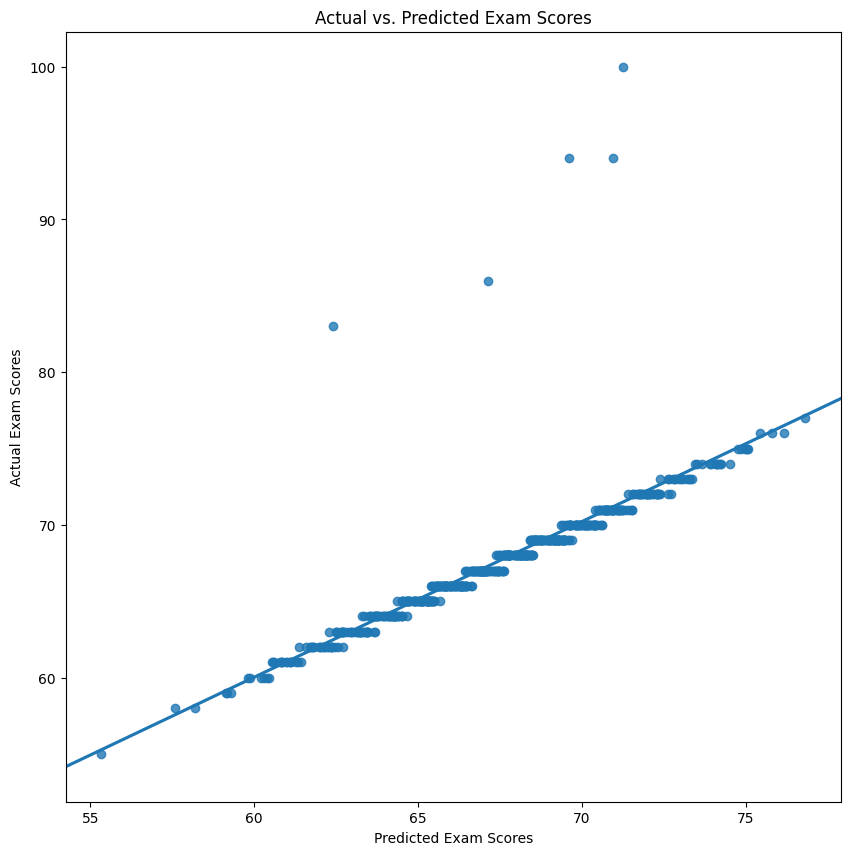

In [39]:
#plots the predicted test scores vs the actual test scores from the holdout data
fig, ax = plt.subplots(figsize=(10, 10))

sns.regplot(y=y_test, x=y_pred_final, ci=None, truncate=False, ax=ax)
ax.set_xlabel('Predicted Exam Scores')
ax.set_ylabel('Actual Exam Scores')
ax.set_title('Actual vs. Predicted Exam Scores')
plt.show()

In [40]:
#Prints the coefficients for my final model in descending order
coef_df = pd.DataFrame({'Feature': X_test_sig.columns, 'Coefficient': final_model.estimator_.coef_})
coef_df = coef_df.sort_values('Coefficient', ascending=False)

print(coef_df)


                                  Feature  Coefficient
1                              Attendance     2.310065
0                           Hours_Studied     1.790376
2                         Previous_Scores     0.718579
3                       Tutoring_Sessions     0.615141
23                Distance_from_Home_Near     0.493905
18                Peer_Influence_Positive     0.490811
12                    Internet_Access_Yes     0.258886
4                       Physical_Activity     0.244028
17                 Peer_Influence_Neutral     0.243190
9          Extracurricular_Activities_Yes     0.240987
22            Distance_from_Home_Moderate     0.227602
21  Parental_Education_Level_Postgraduate     0.205652
14                   Family_Income_Medium    -0.245314
11                Motivation_Level_Medium    -0.250345
16                 Teacher_Quality_Medium    -0.250858
20   Parental_Education_Level_High School    -0.251732
15                    Teacher_Quality_Low    -0.303885
19        

Text(0, 0.5, 'Residuals')

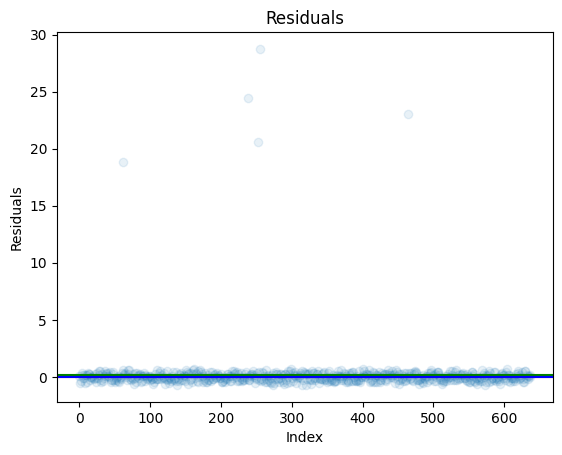

In [41]:
#scatter plot of the residuals to check for heteroskedasticity
resid = (y_test - y_pred_final)

fig, ax = plt.subplots()
ax.set_title('Residuals')
ax.scatter(x=range(y_pred_final.shape[0]), y = resid, alpha=.1);

ax.axhline(y=0, color='r', linestyle='-')
ax.axhline(y=np.mean(resid), color='g', linestyle='-')
ax.axhline(y=-np.median(resid), color='b', linestyle='-')

ax.set_xlabel('Index')
ax.set_ylabel('Residuals')

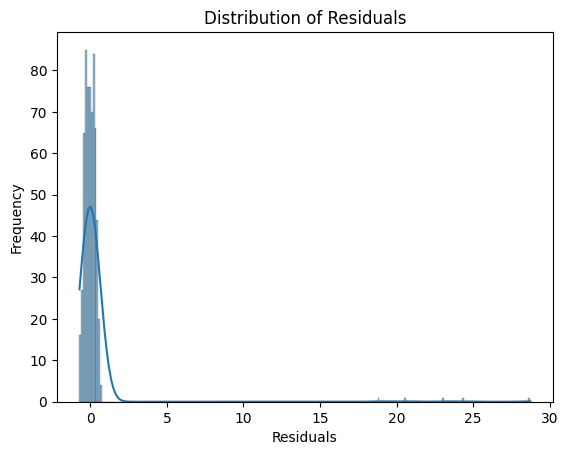

In [42]:
#histogram of the residuals to check for normality
fig, ax = plt.subplots()
sns.histplot(resid, ax=ax, kde=True)
ax.set_title('Distribution of Residuals')
ax.set_xlabel('Residuals')
ax.set_ylabel('Frequency')
plt.show()

### **Conclusions**



*   **Conclusion 1:**  College exam scores are predictable.
*   **Conclusion 2:**  Sleep, Public vs. Private College, and Gender are insignificant in predicting exam scores.
*   **Conclusion 3:** The follwing table shows which features most positively and negatively affect the exam scores. 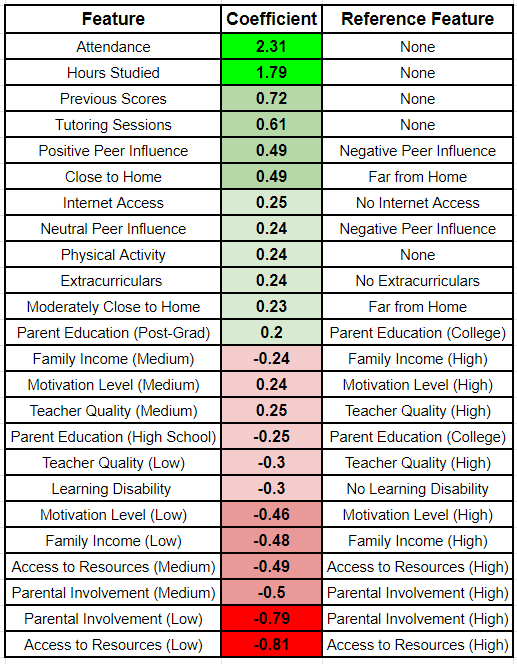



### **Next Steps**



*   **New Features:** The dataset has a wide range of features, but if it includes features such as physical activity and sleep I'd like to have invormation on a feature about diet to see if that's significant to exam scores.  Does the "freshman 15" impact exam scores?

*   **New Populations:** This data analyzes college exams but could these features also apply to high school exams as well?

*  **Application:**  What is the best way to get this information to the target stakeholders?

* **Explore:**  Why is there a dropoff in exam scores after more than 6 tutoring sessions per month?

